## Trabalho Final - Machine Learning
RM: 358770 - Erika Koyanagui

RM: 358488 - Fabio Asnis Campos da Silva

RM: 359283 - Lucas Huber Pissaia

RM: 358477 - Matheus Raeski

Neste trabalho, como parte do time de cientistas da Quantum Finance, exploramos a base de dados disponilizados no drive (https://drive.google.com/drive/folders/1OTU650tmFmeyARV5-lYW7yNacVWPxvOJ?usp=sharing), já suavizados e prontos para uso, para construir um modelo fundo de ações baseado em modelos de Deep Learning.

O objetivo é desenvolver um modelo que tenha como
saída a compra ou venda de um determinada ação baseado na movimentação
do mercado nos últimos 15 dias.
Inicialmente 4 ações foram selecionadas para análise:

• VALE3 – Vale do Rio Doce

• PETR4 – Petrobras

• BBAS3 – Banco do Brasil

• CSNA3 - Companhia Siderúrgica Nacional

Diferentes modelos vão ser utilizados.

Para a VALE3, vamos construir três modelos: CNN 1D, RNN e LSTM, apenas com base no csv sem nenhuma feature a mais.

Para cada companhia, vamos fazer uma análise e aplicação diferente, sendo possível ver os impactos de cada decisão.

A descrição de cada etapa e decisão encontram-se no decorrer do código. Nossas conclusões sobre o trabalho, qual o modelo com melhor resultado assim como futuros passos, encontram-se na etapa final.

# Import & Config

In [ ]:
!pip install -q tensorflow pandas numpy scikit-learn matplotlib seaborn pillow

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import time



import glob, os
from PIL import Image


In [ ]:
#Fixar seed para reprodutibilidade

tf.random.set_seed(42)
np.random.seed(42)

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#• VALE3 – Vale do Rio Doce

# Importar dados

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/VALE3.SA/treino.csv",parse_dates=['Date'], dayfirst=True)
df_test = pd.read_csv("/content/drive/MyDrive/FIAP_PI/VALE3.SA/teste.csv",parse_dates=['Date'], dayfirst=True)

print("Treino:", df_train.shape, "Teste:", df_test.shape)
df_train.head()
df_train['Label'].value_counts(normalize=True)

/tmp/ipython-input-630814044.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/VALE3.SA/treino.csv",parse_dates=['Date'], dayfirst=True)


Treino: (4808, 20) Teste: (1203, 20)


/tmp/ipython-input-630814044.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_test = pd.read_csv("/content/drive/MyDrive/FIAP_PI/VALE3.SA/teste.csv",parse_dates=['Date'], dayfirst=True)


,proportion
Label,
-1,0.564892
1,0.435108


Boa proporção entre compra e venda, se fosse desproporcional poderia ser necessário o uso de class_weight no treino.

# Preparar dados

In [ ]:
# Seleciona as colunas que representam os últimos 15 dias de preços
seq_cols = [f"Past_{i}_Days_Close" for i in range(1, 16)]

# Função para converter uma linha de preços absolutos em retornos normalizados
def row_to_input(arr):
    # arr shape (15,) com preços absolutos
    r = np.diff(arr) / arr[:-1]             # retornos percentuais -> len=14
    r = np.concatenate([[0.0], r])          # insere um 0 no início para manter 15
    r = (r - r.mean()) / (r.std() + 1e-9)   # normalização por amostra
    return r

# Cria arrays de entrada
X_train = np.stack([row_to_input(row) for row in df_train[seq_cols].values])
X_test  = np.stack([row_to_input(row) for row in df_test[seq_cols].values])

# Ajusta forma para Keras: (n_amostras, 15, 1)
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Converte rótulos
y_train = (df_train['Label'] == 1).astype(int).values
y_test  = (df_test['Label'] == 1).astype(int).values

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)


Shape X_train: (4808, 15, 1)
Shape y_train: (4808,)


# Definir os modelos

In [ ]:
#CNN 1D
def build_cnn1d(input_shape=(15,1)):
    inp = keras.Input(shape=input_shape, name="seq_in")
    x = layers.Conv1D(32, 3, activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out, name="CNN1D_seq")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

#RNN
def build_rnn(input_shape):
    inp = keras.Input(shape=input_shape, name="seq_in")
    x = layers.SimpleRNN(64, return_sequences=False)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out, name="RNN_seq")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

#LSTM
def build_lstm(input_shape):
    inp = keras.Input(shape=input_shape, name="seq_in")
    x = layers.LSTM(64, return_sequences=False)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out, name="LSTM_seq")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Treinamento e avaliação


In [ ]:
# definir as funções para treinar e avaliar
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="model"):

    t0 = time.time()

    # Pesos de classe
    cw = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weight = {i: cw[i] for i in range(len(cw))}

    # Callbacks
    os.makedirs("models", exist_ok=True)
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True), # aqui vai influenciar no modelo parar de treinar quando vê que não melhora mais, evita overfitting e economiza tempo
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint(f"models/{model_name}.h5", save_best_only=True, monitor="val_loss")
    ]

    # Treinamento
    history = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=40,
        batch_size=32,
        class_weight=class_weight,
        callbacks=callbacks,
        shuffle=True
    )

    tempo_total = time.time() - t0

    # Avaliação
    model.load_weights(f"models/{model_name}.h5")
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {model_name.upper()} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["vender","comprar"]))
    print(f"Tempo total de treino + avaliação: {tempo_total:.2f} segundos")

    cm = confusion_matrix(y_test, y_pred)
    sb.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["vender","comprar"], yticklabels=["vender","comprar"])
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()


# Execução dos modelos

Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5602 - loss: 0.6829

128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.5603 - loss: 0.6828 - val_accuracy: 0.5693 - val_loss: 0.6696 - learning_rate: 0.0010
Epoch 2/40
107/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 0.6667

128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6082 - loss: 0.6663 - val_accuracy: 0.6150 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 3/40
111/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6175 - loss: 0.6553

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6170 - loss: 0.6554 - val_accuracy: 0.6108 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 4/40
113/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6247 - loss: 0.6502

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6243 - loss: 0.6503 - val_accuracy: 0.6219 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 5/40
123/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6169 - loss: 0.6492

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6171 - loss: 0.6491 - val_accuracy: 0.6247 - val_loss: 0.6512 - learning_rate: 0.0010
Epoch 6/40
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6340 - loss: 0.6418

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6339 - loss: 0.6418 - val_accuracy: 0.6330 - val_loss: 0.6494 - learning_rate: 0.0010
Epoch 7/40
115/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6302 - loss: 0.6421

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6311 - loss: 0.6418 - val_accuracy: 0.6330 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 8/40
112/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 0.6360

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6362 - loss: 0.6361 - val_accuracy: 0.6385 - val_loss: 0.6435 - learning_rate: 0.0010
Epoch 9/40
111/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 0.6349

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6424 - loss: 0.6346 - val_accuracy: 0.6371 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 10/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6427 - loss: 0.6326 - val_accuracy: 0.6371 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 11/40
122/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6470 - loss: 0.6292

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6473 - loss: 0.6291 - val_accuracy: 0.6496 - val_loss: 0.6402 - learning_rate: 0.0010
Epoch 12/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.6229

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6532 - loss: 0.6229 - val_accuracy: 0.6427 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 13/40
112/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6514 - loss: 0.6252

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6523 - loss: 0.6248 - val_accuracy: 0.6440 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 14/40
109/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6657 - loss: 0.6212

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6663 - loss: 0.6207 - val_accuracy: 0.6427 - val_loss: 0.6353 - learning_rate: 0.0010
Epoch 15/40
109/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.6189

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6602 - loss: 0.6180 - val_accuracy: 0.6537 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 16/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6757 - loss: 0.6074 - val_accuracy: 0.6399 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 17/40
108/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6742 - loss: 0.6024

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6742 - loss: 0.6023 - val_accuracy: 0.6510 - val_loss: 0.6274 - learning_rate: 0.0010
Epoch 18/40
109/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6714 - loss: 0.6019

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6726 - loss: 0.6013 - val_accuracy: 0.6524 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 19/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6680 - loss: 0.5998

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.5997 - val_accuracy: 0.6579 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 20/40
113/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6797 - loss: 0.5937

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6799 - loss: 0.5936 - val_accuracy: 0.6565 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 21/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6842 - loss: 0.5930

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6842 - loss: 0.5929 - val_accuracy: 0.6565 - val_loss: 0.6175 - learning_rate: 0.0010
Epoch 22/40
111/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6793 - loss: 0.5883

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6802 - loss: 0.5880 - val_accuracy: 0.6662 - val_loss: 0.6124 - learning_rate: 0.0010
Epoch 23/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6946 - loss: 0.5788 - val_accuracy: 0.6620 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 24/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6942 - loss: 0.5766

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6944 - loss: 0.5765 - val_accuracy: 0.6745 - val_loss: 0.6084 - learning_rate: 0.0010
Epoch 25/40
111/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7056 - loss: 0.5730

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7056 - loss: 0.5725 - val_accuracy: 0.6787 - val_loss: 0.6044 - learning_rate: 0.0010
Epoch 26/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7051 - loss: 0.5562 - val_accuracy: 0.6690 - val_loss: 0.6067 - learning_rate: 0.0010
Epoch 27/40
118/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6973 - loss: 0.5601

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6983 - loss: 0.5597 - val_accuracy: 0.6745 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 28/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6977 - loss: 0.5631 - val_accuracy: 0.6773 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 29/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7111 - loss: 0.5408 - val_accuracy: 0.6814 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 30/40
112/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7405 - loss: 0.5362

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7385 - loss: 0.5373 - val_accuracy: 0.6787 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 31/40
121/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7228 - loss: 0.5387

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7231 - loss: 0.5387 - val_accuracy: 0.6898 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 32/40
108/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7306 - loss: 0.5378

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7312 - loss: 0.5366 - val_accuracy: 0.6994 - val_loss: 0.5839 - learning_rate: 0.0010
Epoch 33/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7332 - loss: 0.5280 - val_accuracy: 0.6814 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 34/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7382 - loss: 0.5262 - val_accuracy: 0.6856 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 35/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.5232

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7458 - loss: 0.5231 - val_accuracy: 0.6981 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 36/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7421 - loss: 0.5053 - val_accuracy: 0.6842 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 37/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - loss: 0.5254

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.5253 - val_accuracy: 0.6967 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 38/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7464 - loss: 0.5027 - val_accuracy: 0.6884 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 39/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7626 - loss: 0.5023 - val_accuracy: 0.6953 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 40/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7546 - loss: 0.4984 - val_accuracy: 0.6870 - val_loss: 0.5765 - learning_rate: 0.0010
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== CNN1D_VALE ===
Accuracy: 0.6924355777223608
              precision    recall  f1-score   support

      vender       0.68      0.72      0.70       601
     comprar       0.70      0.67      0.68       602

    accuracy                           0.69      1203
   macro avg       0.69      0.69      0.69      1203
weighted avg       0.69      0.69      

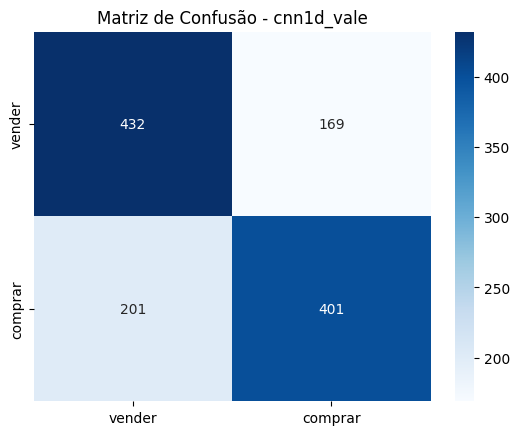

Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6189 - loss: 0.6331

128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6195 - loss: 0.6325 - val_accuracy: 0.8476 - val_loss: 0.3571 - learning_rate: 0.0010
Epoch 2/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8409 - loss: 0.3560

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8412 - loss: 0.3552 - val_accuracy: 0.8961 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 3/40
116/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8627 - loss: 0.3152

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8629 - loss: 0.3140 - val_accuracy: 0.8906 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 4/40
120/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8787 - loss: 0.2899

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8787 - loss: 0.2897 - val_accuracy: 0.8975 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 5/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8735 - loss: 0.2846

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8737 - loss: 0.2844 - val_accuracy: 0.9017 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 6/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8724 - loss: 0.2879

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8728 - loss: 0.2873 - val_accuracy: 0.8947 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 7/40
120/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8846 - loss: 0.2742

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8849 - loss: 0.2733 - val_accuracy: 0.9003 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 8/40
122/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8848 - loss: 0.2746

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8850 - loss: 0.2739 - val_accuracy: 0.9044 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 9/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8813 - loss: 0.2731 - val_accuracy: 0.8975 - val_loss: 0.2488 - learning_rate: 0.0010
Epoch 10/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8931 - loss: 0.2619 - val_accuracy: 0.9003 - val_loss: 0.2475 - learning_rate: 0.0010
Epoch 11/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8810 - loss: 0.2623 - val_accuracy: 0.9017 - val_loss: 0.2468 - learning_rate: 0.0010
Epoch 12/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8972 - loss: 0.2515 - val_accuracy: 0.9017 - val_loss: 0.2584 - learning_rate: 5.0000e-04
Epoch 13/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8913 - loss: 0.2461 - val_accuracy: 0.9003 - val_loss: 0.2587 - learning_rate: 5.0000e-04
Epoch 14/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8953 - loss: 0.2466 

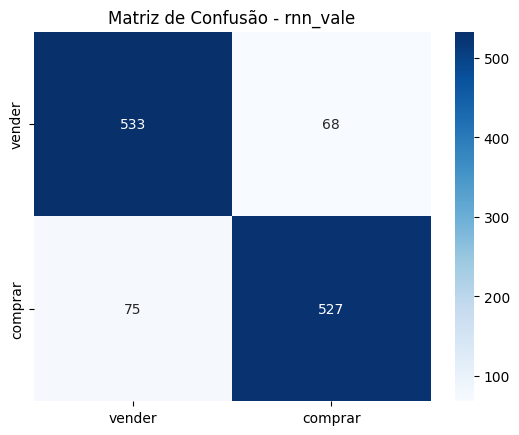

Epoch 1/40
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5665 - loss: 0.6816

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5666 - loss: 0.6816 - val_accuracy: 0.5665 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 2/40
121/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5857 - loss: 0.6728

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5862 - loss: 0.6727 - val_accuracy: 0.5831 - val_loss: 0.6582 - learning_rate: 0.0010
Epoch 3/40
120/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6182 - loss: 0.6524

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6183 - loss: 0.6522 - val_accuracy: 0.6288 - val_loss: 0.6312 - learning_rate: 0.0010
Epoch 4/40
121/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6635 - loss: 0.6238

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6631 - loss: 0.6235 - val_accuracy: 0.6911 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 5/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6920 - loss: 0.5931

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6923 - loss: 0.5927 - val_accuracy: 0.8061 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 6/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7858 - loss: 0.4565

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7862 - loss: 0.4560 - val_accuracy: 0.8393 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 7/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8220 - loss: 0.3891

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8224 - loss: 0.3885 - val_accuracy: 0.8795 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 8/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8412 - loss: 0.3521

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8414 - loss: 0.3516 - val_accuracy: 0.8712 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 9/40
122/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8563 - loss: 0.3210

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8564 - loss: 0.3206 - val_accuracy: 0.8878 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 10/40
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8597 - loss: 0.3057

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8599 - loss: 0.3055 - val_accuracy: 0.8947 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 11/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8612 - loss: 0.2975 - val_accuracy: 0.8767 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 12/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8587 - loss: 0.3170 - val_accuracy: 0.8864 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 13/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8652 - loss: 0.3010 - val_accuracy: 0.8615 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 14/40
123/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8663 - loss: 0.2979

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8666 - loss: 0.2971 - val_accuracy: 0.8975 - val_loss: 0.2384 - learning_rate: 5.0000e-04
Epoch 15/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8753 - loss: 0.2794 - val_accuracy: 0.8947 - val_loss: 0.2386 - learning_rate: 5.0000e-04
Epoch 16/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8735 - loss: 0.2758 - val_accuracy: 0.8920 - val_loss: 0.2406 - learning_rate: 5.0000e-04
Epoch 17/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8749 - loss: 0.2798 - val_accuracy: 0.8947 - val_loss: 0.2428 - learning_rate: 5.0000e-04
Epoch 18/40
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8739 - loss: 0.2767

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8740 - loss: 0.2765 - val_accuracy: 0.9100 - val_loss: 0.2226 - learning_rate: 2.5000e-04
Epoch 19/40
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8806 - loss: 0.2659

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8807 - loss: 0.2658 - val_accuracy: 0.9100 - val_loss: 0.2212 - learning_rate: 2.5000e-04
Epoch 20/40
122/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.2680

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8789 - loss: 0.2676 - val_accuracy: 0.9100 - val_loss: 0.2192 - learning_rate: 2.5000e-04
Epoch 21/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8827 - loss: 0.2683 - val_accuracy: 0.9100 - val_loss: 0.2220 - learning_rate: 2.5000e-04
Epoch 22/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8780 - loss: 0.2700 - val_accuracy: 0.9114 - val_loss: 0.2203 - learning_rate: 2.5000e-04
Epoch 23/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8799 - loss: 0.2656 - val_accuracy: 0.9114 - val_loss: 0.2194 - learning_rate: 2.5000e-04
Epoch 24/40
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8793 - loss: 0.2655

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8795 - loss: 0.2652 - val_accuracy: 0.9072 - val_loss: 0.2159 - learning_rate: 1.2500e-04
Epoch 25/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8877 - loss: 0.2610 - val_accuracy: 0.9155 - val_loss: 0.2166 - learning_rate: 1.2500e-04
Epoch 26/40
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8782 - loss: 0.2657

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8785 - loss: 0.2654 - val_accuracy: 0.9086 - val_loss: 0.2154 - learning_rate: 1.2500e-04
Epoch 27/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8833 - loss: 0.2590 - val_accuracy: 0.9086 - val_loss: 0.2156 - learning_rate: 1.2500e-04
Epoch 28/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8832 - loss: 0.2639 - val_accuracy: 0.9141 - val_loss: 0.2163 - learning_rate: 1.2500e-04
Epoch 29/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8816 - loss: 0.2622 - val_accuracy: 0.9155 - val_loss: 0.2168 - learning_rate: 1.2500e-04
Epoch 30/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8839 - loss: 0.2628

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8840 - loss: 0.2628 - val_accuracy: 0.9072 - val_loss: 0.2147 - learning_rate: 6.2500e-05
Epoch 31/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8830 - loss: 0.2622 - val_accuracy: 0.9100 - val_loss: 0.2148 - learning_rate: 6.2500e-05
Epoch 32/40
122/128 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.2581

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8822 - loss: 0.2579 - val_accuracy: 0.9086 - val_loss: 0.2142 - learning_rate: 6.2500e-05
Epoch 33/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8835 - loss: 0.2594 - val_accuracy: 0.9086 - val_loss: 0.2145 - learning_rate: 6.2500e-05
Epoch 34/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8848 - loss: 0.2604 - val_accuracy: 0.9086 - val_loss: 0.2143 - learning_rate: 6.2500e-05
Epoch 35/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8850 - loss: 0.2619 - val_accuracy: 0.9086 - val_loss: 0.2146 - learning_rate: 6.2500e-05
Epoch 36/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8863 - loss: 0.2579 - val_accuracy: 0.9100 - val_loss: 0.2142 - learning_rate: 3.1250e-05
Epoch 37/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8854 - loss: 0.2580 - val_accuracy: 0.9086 - val_loss: 0.2147 - learning_rate: 3.1250e-05
Epoch 38/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.

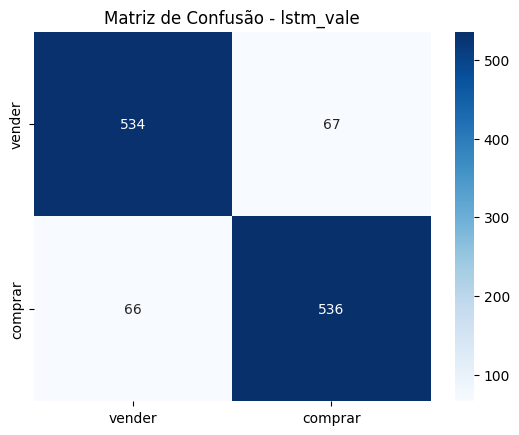

In [ ]:
# CNN 1D
cnn1d = build_cnn1d(X_train.shape[1:])
train_and_evaluate(cnn1d, X_train, y_train, X_test, y_test, model_name="cnn1d_vale")

# RNN
rnn = build_rnn(X_train.shape[1:])
train_and_evaluate(rnn, X_train, y_train, X_test, y_test, model_name="rnn_vale")

# LSTM
lstm = build_lstm(X_train.shape[1:])
train_and_evaluate(lstm, X_train, y_train, X_test, y_test, model_name="lstm_vale")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
        Accuracy  Precision    Recall        F1
Modelo                                         
CNN1D   0.692436   0.703509  0.666113  0.684300
RNN     0.881131   0.885714  0.875415  0.880535
LSTM    0.889443   0.888889  0.890365  0.889627


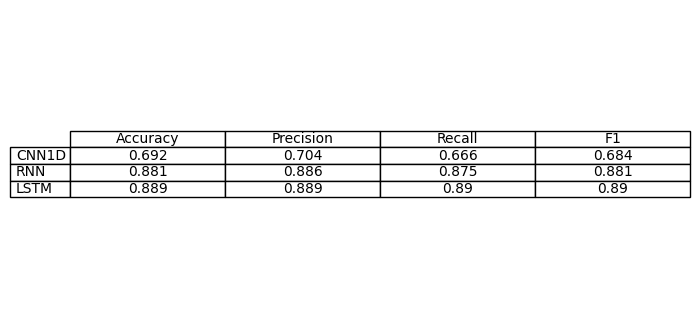

In [ ]:
# Reunindo em uma tabela os resultados

def avaliar_modelo(model, X_test, y_test, nome):
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "Modelo": nome,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)

      }

# Avalia cada um
resultados = []
resultados.append(avaliar_modelo(cnn1d, X_test, y_test, "CNN1D"))
resultados.append(avaliar_modelo(rnn, X_test, y_test, "RNN"))
resultados.append(avaliar_modelo(lstm, X_test, y_test, "LSTM"))

# Cria dataframe
df_resultados = pd.DataFrame(resultados).set_index("Modelo")
print(df_resultados)

# Tabela formatada
plt.figure(figsize=(8,4))
plt.axis('off')
plt.table(cellText=df_resultados.round(3).values,
          rowLabels=df_resultados.index,
          colLabels=df_resultados.columns,
          cellLoc='center',
          loc='center')
plt.show()


## Resultados
1. CNN1D (Accuracy ~69%)
Traz um resultado melhor do que só um chute (50%), mas está relativamente fraca em capturar padrões.

Precision/Recall equilibrados (~0.70/0.67): não está enviesada para um lado só, tem uma precisão parecida para compra ou venda, o que se reflete na matriz de confusão.

O modelo foi um pouco melhor para acertar a venda, mas falhou mais quando tinha que comprar e acabou por vendar

CNNs 1D são boas em detectar padrões locais em séries temporais (como pequenas tendências nos preços), mas podem perder a dependência sequencial mais longa (como movimentos que se acumulam ao longo dos 15 dias).


2. RNN (Accuracy ~88%)

O segundo modelo teve uma melhora significativa.

Precision e Recall equilibrados (≈0.88–0.87) → modelo consistente tanto em prever compra quanto venda. Na matriz de confusão vemos os acertos para venda e compra muito próximos, assim como os erros também

RNN consegue aprender dependências sequenciais ao longo do tempo (sendo um ótimo “perseguidor de tendência”).

Foi o modelo mais rápido, demorando cerca de 21 segundos.

3. LSTM (Accuracy ~89%)

Ainda melhor que a RNN simples.

Precision/Recall muito balanceados (~0.88–0.90) → modelo robusto e confiável, sem viés para um lado só. A matriz de confusão está quase igualada, tendo uma variação mínima entre as partes.

LSTM tem mecanismos de memória (gates) que ajudam a reter e esquecer informações relevantes ao longo da janela temporal → captura melhor tendências suaves ou reversões.

O modelo mais lento.

## Conclusões até aqui:
- O modelo perseguidor de tendência de fato está funcionando, principalmente nos modelos recorrentes (RNN/LSTM).

- A CNN1D foi a mais fraca, mas ainda serve como baseline.

- Olhando apenas para a acurácia e tempo, o modelo escolhido aqui seria o RNN, teve uma acurácia alta mas levou apenas metade do tempo do LSTM.

Próximos passos:

Rodar o backtest para cada modelo e comparar o retorno financeiro, não apenas a acurácia.

# Backtest

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Valor final (CNN): R$ 10014.47


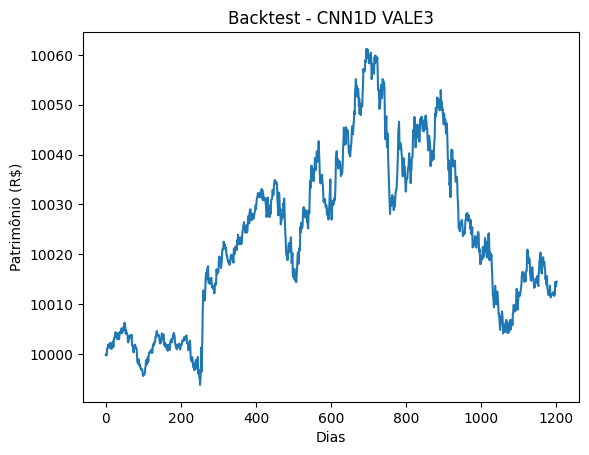


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Valor final (RNN): R$ 9996.79


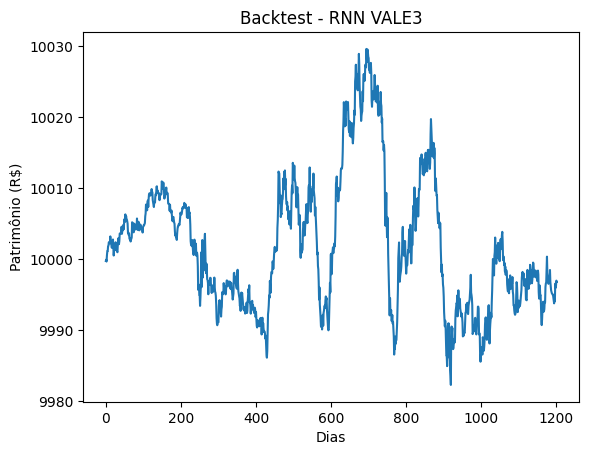

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Valor final (LSTM): R$ 10024.59


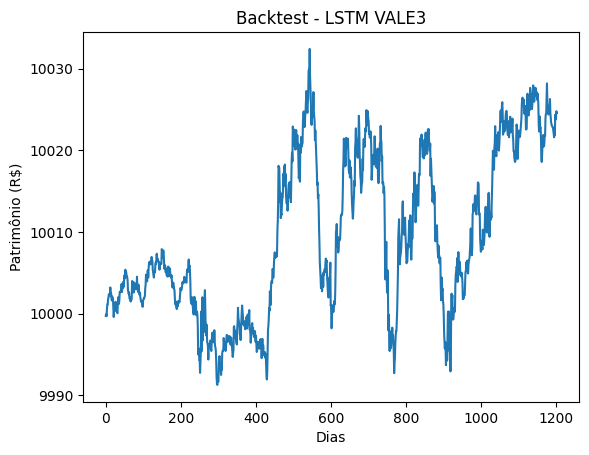

In [ ]:
def backtest(model, X, y_true, df, capital_inicial=10000):
    capital = capital_inicial
    posicao = 0  # +1 compra, -1 venda
    patrimonio = []

    y_prob = model.predict(X).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # usa coluna de fechamento real
    prices = df['Close'].values

    for i in range(len(y_pred) - 1):
        if y_pred[i] == 1:  # sinal de COMPRA
            if posicao <= 0:
                posicao = 1
                preco_entrada = prices[i]
        else:  # sinal de VENDA
            if posicao >= 0:
                posicao = -1
                preco_entrada = prices[i]

        # atualiza patrimônio pelo movimento do dia seguinte
        if posicao == 1:
            capital += (prices[i+1] - prices[i])
        elif posicao == -1:
            capital += (prices[i] - prices[i+1])

        patrimonio.append(capital)

    return patrimonio


# CNN
patrimonio_cnn = backtest(cnn1d, X_test, y_test, df_test, capital_inicial=10000)
print("Valor final (CNN): R$ {:.2f}".format(patrimonio_cnn[-1]))

plt.plot(patrimonio_cnn)
plt.title("Backtest - CNN1D VALE3")
plt.xlabel("Dias")
plt.ylabel("Patrimônio (R$)")
plt.show()
print()
# RNN
patrimonio_rnn = backtest(rnn, X_test, y_test, df_test, capital_inicial=10000)
print("Valor final (RNN): R$ {:.2f}".format(patrimonio_rnn[-1]))

plt.plot(patrimonio_rnn)
plt.title("Backtest - RNN VALE3")
plt.xlabel("Dias")
plt.ylabel("Patrimônio (R$)")
plt.show()

# LSTM
patrimonio_lstm = backtest(lstm, X_test, y_test, df_test, capital_inicial=10000)
print("Valor final (LSTM): R$ {:.2f}".format(patrimonio_lstm[-1]))

plt.plot(patrimonio_lstm)
plt.title("Backtest - LSTM VALE3")
plt.xlabel("Dias")
plt.ylabel("Patrimônio (R$)")
plt.show()


## Resultados backtest

Aqui temos uma surpresa, visto os resultados de acurácia encontrados anteriormente.

- Valor final (CNN): R$ 10014.47

- Valor final (RNN): R$ 9996.79

- Valor final (LSTM): R$ 10024.59

O modelo que performou melhor não foi o com maior acurácia. Isso pode ter sido pelos "erros" do modelo terem custado mais do que os acertos e ganhos.
Todos os modelos ficaram próximos do empate, tendo um resultado que não justifaria o uso.
Um ponto importante também, é que mesmo no backtest só há duas opções: compra e venda. O modelo não se mantém neutro face a alta volatilidade ou baixa precisão, por exemplo.

# PETR4 - Petrobras

Para a Petrobras, vamos seguir analisando apenas o csv, mas agora com a adição de mais features para os mesmos três modelos utilizados.

As features que vamos incluir são:
* Retornos (momentum) -> para captar direção de curto/médio prazo (tendência ou reversão);
* Médias móveis -> indicadores clássicos de tendência, 5 e 15 dias para mudanças curtas e a direção principal;
* Volatidade -> Risco/instabilidade, mostra quebras de tendência;

Vamos utilizar o valor da ação do dia anterior, para garantir que não estamos utilizando o valor do fechamento do próprio dia para tomar a decisão.

# Importar dados

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/PETR4.SA/treino.csv", parse_dates=['Date'], dayfirst=True)
df_test  = pd.read_csv("/content/drive/MyDrive/FIAP_PI/PETR4.SA/teste.csv", parse_dates=['Date'], dayfirst=True)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.head())


Train shape: (4808, 20)
Test shape: (1203, 20)
   Unnamed: 0       Date     Close  Smoothed_Close  Label  Past_1_Days_Close  \
0           1 2000-01-24  1.274788        1.347845     -1           1.283923   
1           2 2000-01-25  1.274788        1.340540     -1           1.274788   
2           3 2000-01-26  1.290096        1.335495     -1           1.274788   
3           4 2000-01-27  1.280960        1.330042     -1           1.290096   
4           5 2000-01-28  1.280960        1.325134     -1           1.280960   

   Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  Past_5_Days_Close  \
0           1.311824           1.314787           1.324169           1.317996   
1           1.283923           1.311824           1.314787           1.324169   
2           1.274788           1.283923           1.311824           1.314787   
3           1.274788           1.274788           1.283923           1.311824   
4           1.290096           1.274788           1.274788         

/tmp/ipython-input-2342377694.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/PETR4.SA/treino.csv", parse_dates=['Date'], dayfirst=True)
/tmp/ipython-input-2342377694.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_test  = pd.read_csv("/content/drive/MyDrive/FIAP_PI/PETR4.SA/teste.csv", parse_dates=['Date'], dayfirst=True)


# Preparar dados com novas features


In [ ]:
# Funções auxiliares
def SMA(series, window): return series.rolling(window).mean() # média móvel simples
def EMA(series, window): return series.ewm(span=window, adjust=False).mean() # média móvel exponencial

# Criar features adicionais
for df in [df_train, df_test]:
    # Retornos (momentum)
    df['Return_1d'] = df['Past_1_Days_Close'].pct_change(1)
    df['Return_5d'] = df['Past_1_Days_Close'].pct_change(5)
    df['Return_15d'] = df['Past_1_Days_Close'].pct_change(15)

    # Médias móveis do dia anterior
    df['SMA5'] = SMA(df['Past_1_Days_Close'], 5)
    df['SMA15'] = SMA(df['Past_1_Days_Close'], 15)
    df['EMA5'] = EMA(df['Past_1_Days_Close'], 5)
    df['EMA15'] = EMA(df['Past_1_Days_Close'], 15)

    # Volatilidade 15 dias
    df['Volatility15'] = df['Past_1_Days_Close'].pct_change().rolling(15).std()

# Remove NaNs iniciais
df_train = df_train.dropna().reset_index(drop=True)
df_test  = df_test.dropna().reset_index(drop=True)

print("Features criadas:", [c for c in df_train.columns if c not in ['Date','Label']][:10], "...")
print("Total de features novas:", len(df_train.columns))


Features criadas: ['Unnamed: 0', 'Close', 'Smoothed_Close', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close'] ...
Total de features novas: 28


In [ ]:
# Sequência dos últimos 15 dias

seq_cols = [f"Past_{i}_Days_Close" for i in range(1, 16)]

def row_to_input(arr):
    # arr shape (15,) com preços absolutos
    r = np.diff(arr) / arr[:-1]             # retornos percentuais (len=14)
    r = np.concatenate([[0.0], r])          # insere 0 no início para manter 15
    r = (r - r.mean()) / (r.std() + 1e-9)   # normalização por amostra
    return r

X_train_seq = np.stack([row_to_input(row) for row in df_train[seq_cols].values])
X_test_seq  = np.stack([row_to_input(row) for row in df_test[seq_cols].values])

# Ajusta formato para Keras (n_amostras, 15, 1)
X_train_seq = X_train_seq[..., np.newaxis]
X_test_seq  = X_test_seq[..., np.newaxis]

print("X_train_seq shape:", X_train_seq.shape)


# Agora adicionamos as features

feat_cols = [c for c in df_train.columns
             if c not in ['Date','Label'] + seq_cols]

scaler = StandardScaler()
X_train_feat = scaler.fit_transform(df_train[feat_cols])
X_test_feat  = scaler.transform(df_test[feat_cols])

print("X_train_feat shape:", X_train_feat.shape)

# Converte rótulos
y_train = (df_train['Label'] == 1).astype(int).values
y_test  = (df_test['Label'] == 1).astype(int).values

print("y_train shape:", y_train.shape, " - classes:", np.unique(y_train, return_counts=True))


X_train_seq shape: (4793, 15, 1)
X_train_feat shape: (4793, 11)
y_train shape: (4793,)  - classes: (array([0, 1]), array([2643, 2150]))


# Definir os modelos com as features

In [ ]:
# CNN1D + features
def build_cnn1d_dual(seq_shape, feat_dim):
    # Ramo sequência
    seq_in = keras.Input(shape=seq_shape, name="seq_in")
    x = layers.Conv1D(32, 3, activation="relu")(seq_in)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    seq_branch = layers.Dense(32, activation="relu")(x)

    # Ramo features
    feat_in = keras.Input(shape=(feat_dim,), name="feat_in")
    y = layers.Dense(32, activation="relu")(feat_in)
    y = layers.Dropout(0.2)(y)
    feat_branch = layers.Dense(16, activation="relu")(y)

    # Combinação
    combined = layers.concatenate([seq_branch, feat_branch])
    z = layers.Dense(32, activation="relu")(combined)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model([seq_in, feat_in], out, name="CNN1D_dual")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# RNN + features
def build_rnn_dual(seq_shape, feat_dim, cell=layers.SimpleRNN):
    # Ramo sequência
    seq_in = keras.Input(shape=seq_shape, name="seq_in")
    x = layers.SimpleRNN(64, return_sequences=False)(seq_in)
    x = layers.Dropout(0.2)(x)
    seq_branch = layers.Dense(32, activation="relu")(x)

    # Ramo features
    feat_in = keras.Input(shape=(feat_dim,), name="feat_in")
    y = layers.Dense(32, activation="relu")(feat_in)
    y = layers.Dropout(0.2)(y)
    feat_branch = layers.Dense(16, activation="relu")(y)

    # Combinação
    combined = layers.concatenate([seq_branch, feat_branch])
    z = layers.Dense(32, activation="relu")(combined)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model([seq_in, feat_in], out, name="RNN_dual")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# LSTM + features
def build_lstm_dual(seq_shape, feat_dim):
    # Ramo sequência
    seq_in = keras.Input(shape=seq_shape, name="seq_in")
    x = layers.LSTM(64, return_sequences=False)(seq_in)
    x = layers.Dropout(0.2)(x)
    seq_branch = layers.Dense(32, activation="relu")(x)

    # Ramo features
    feat_in = keras.Input(shape=(feat_dim,), name="feat_in")
    y = layers.Dense(32, activation="relu")(feat_in)
    y = layers.Dropout(0.2)(y)
    feat_branch = layers.Dense(16, activation="relu")(y)

    # Combinação
    combined = layers.concatenate([seq_branch, feat_branch])
    z = layers.Dense(32, activation="relu")(combined)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model([seq_in, feat_in], out, name="LSTM_dual")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# treinamento + avaliação (multi-entrada)
def train_eval_dual(model, Xseq_tr, Xfeat_tr, y_tr, Xseq_te, Xfeat_te, y_te, name):
    t0 = time.time()

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ]
    history = model.fit(
        {"seq_in": Xseq_tr, "feat_in": Xfeat_tr}, y_tr,
        validation_split=0.15, epochs=50, batch_size=32, shuffle=True,
        callbacks=callbacks, verbose=0
    )

    tempo_total = time.time() - t0

    y_prob = model.predict({"seq_in": Xseq_te, "feat_in": Xfeat_te}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {name.upper()} (15 dias + features) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['vender','comprar']))
    print(f"Tempo total de treino + avaliação: {tempo_total:.2f} segundos")

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['vender','comprar'], yticklabels=['vender','comprar'])
    plt.title(name)
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()

    return model, history





# Treinamento, avaliação e backtest com features


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== CNN1D_DUAL (15 dias + features) ===
Accuracy: 0.8703703703703703
              precision    recall  f1-score   support

      vender       0.87      0.86      0.87       581
     comprar       0.87      0.88      0.87       607

    accuracy                           0.87      1188
   macro avg       0.87      0.87      0.87      1188
weighted avg       0.87      0.87      0.87      1188

Tempo total de treino + avaliação: 37.06 segundos


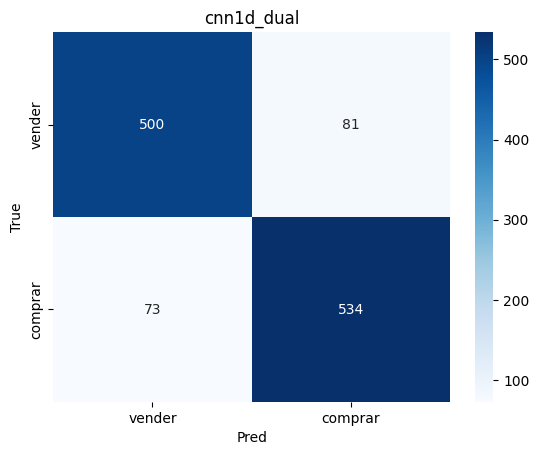

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

=== RNN_DUAL (15 dias + features) ===
Accuracy: 0.877104377104377
              precision    recall  f1-score   support

      vender       0.85      0.91      0.88       581
     comprar       0.90      0.85      0.88       607

    accuracy                           0.88      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.88      0.88      0.88      1188

Tempo total de treino + avaliação: 52.20 segundos


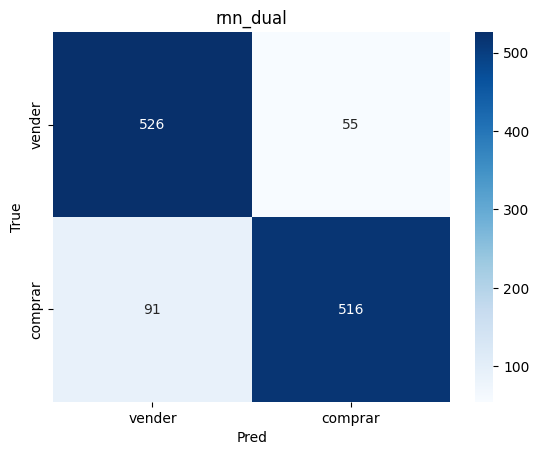

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== LSTM_DUAL (15 dias + features) ===
Accuracy: 0.8779461279461279
              precision    recall  f1-score   support

      vender       0.91      0.84      0.87       581
     comprar       0.85      0.92      0.88       607

    accuracy                           0.88      1188
   macro avg       0.88      0.88      0.88      1188
weighted avg       0.88      0.88      0.88      1188

Tempo total de treino + avaliação: 26.00 segundos


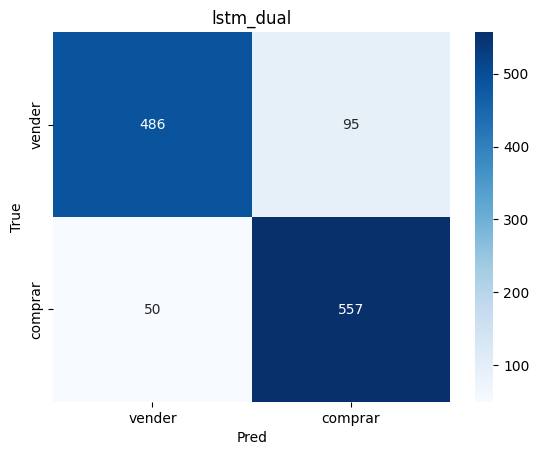

In [ ]:
# constrói
cnn_dual  = build_cnn1d_dual(X_train_seq.shape[1:], X_train_feat.shape[1])
rnn_dual  = build_rnn_dual (X_train_seq.shape[1:], X_train_feat.shape[1])
lstm_dual = build_lstm_dual(X_train_seq.shape[1:], X_train_feat.shape[1])

# treina/avalia
cnn_dual,  _ = train_eval_dual(cnn_dual,  X_train_seq, X_train_feat, y_train, X_test_seq, X_test_feat, y_test, "cnn1d_dual")
rnn_dual,  _ = train_eval_dual(rnn_dual,  X_train_seq, X_train_feat, y_train, X_test_seq, X_test_feat, y_test, "rnn_dual")
lstm_dual, _ = train_eval_dual(lstm_dual, X_train_seq, X_train_feat, y_train, X_test_seq, X_test_feat, y_test, "lstm_dual")



38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Valor final (CNN1D_dual): R$ 15977.66
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Valor final (RNN_dual): R$ 10259.05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Valor final (LSTM_dual): R$ 14969.05


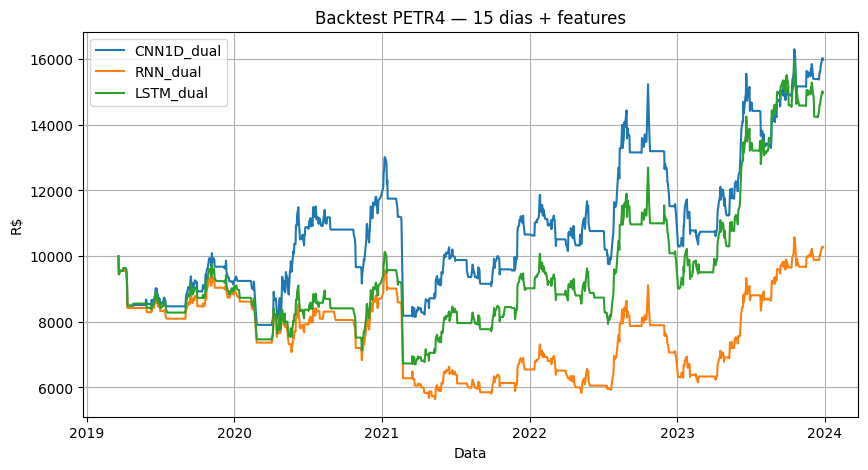

       Modelo  Valor final (R$)
0  CNN1D+feat      15977.656045
1    RNN+feat      10259.053955
2   LSTM+feat      14969.052381


In [ ]:
# backtest reaproveitando a função do híbrido
def backtest_dual(model, Xseq, Xfeat, df, capital_inicial=10000, taxa=0.001):
    capital, pos = capital_inicial, 0.0
    patrimonio = []
    prices = df["Close"].values
    y_prob = model.predict({"seq_in": Xseq, "feat_in": Xfeat}).ravel()
    sig = (y_prob >= 0.5).astype(int)
    for i, s in enumerate(sig):
        p = prices[i]
        if s == 1 and capital > 0:        # compra
            q = (capital * (1 - taxa)) / p
            pos += q
            capital = 0
        elif s == 0 and pos > 0:          # vende
            capital += pos * p * (1 - taxa)
            pos = 0
        patrimonio.append(capital + pos * p)
    final = patrimonio[-1]
    print(f"Valor final ({model.name}): R$ {final:.2f}")
    plt.plot(df["Date"], patrimonio, label=model.name)
    return final, np.array(patrimonio)

# executa e plota juntos
plt.figure(figsize=(10,5))
f_cnn, pat_cnn   = backtest_dual(cnn_dual,  X_test_seq, X_test_feat, df_test)
f_rnn, pat_rnn   = backtest_dual(rnn_dual,  X_test_seq, X_test_feat, df_test)
f_lstm, pat_lstm = backtest_dual(lstm_dual, X_test_seq, X_test_feat, df_test)
plt.legend(); plt.title("Backtest PETR4 — 15 dias + features"); plt.xlabel("Data"); plt.ylabel("R$")
plt.grid(True); plt.show()

# tabela comparativa rápida
import pandas as pd
df_bt = pd.DataFrame({
    "Modelo": ["CNN1D+feat","RNN+feat","LSTM+feat"],
    "Valor final (R$)": [f_cnn, f_rnn, f_lstm]
})
print(df_bt)


## Resultados

Todos os modelos tiveram uma acurácia alta, atingindo ~87%.
Ao mesmo tempo, temos precisão e recall equilibrados, o que nos mostra que nenhum modelo favore apenas uma classe (compra ou venda), mas sim consegue capturar ambas as direções de tendência.

Essa melhora também é vista no backtest, com alguns modelos chegando a ganhos próximos a R$ 6.000,00. Sendo o campeão O CNN1D.

Aqui, como no caso da VALE3, também vemos que nem sempre quem possui a melhor acurácia ou precisão/recall no teste estatístico, garante o melhor resultado financeiro.

A inclusão de features adicionais deu um salto de qualidade em todos os modelos, olhar apenas para a tendência dos últimos 15 dias nos trouxe bons resultados em termos de acurácia, mas os resultados para PETR4 nos mostram que adicionar métricas financeiras como médias móveis, volatilidade e retorno nos traz muitos ganhos, de fato enriquecem ainda mais o modelo.

O que nos diz também que a riqueza das features é tão ou até mais importante que o tipo de arquitetura.

Melhoram o suficiente para justificar a diferença de tempo, já que todos os modelos levaram mais tempo.




# BBAS3 – Banco do Brasil

Agora que já temos os resultados para o uso apenas dos 15 dias + features, provando a combinação ser o melhor, o próximo passo é testar uma mescla e fazer um modelo híbrido.

É o que vamos fazer para o BBAS3.

* Combinar as entradas, utilizando CNN1D, RNN ou LSTM para a sequência de 15 dias, com MLP para as features derivadas.

* O uso aqui do MLP se justifica quando sabemos que as features são tabelares e independentes, sendo uma melhor escolha do que redes focadas em estruturas temporais.

* Poderíamos também fazer um Ensemble clássico de (CNN + RNN + LSTM), mas essa estratégia treina os modelos independentes e faz a junção no final (seja por média ou votação).

* O que queremos treinar é um aprendizado conjunto, por isso a escolha do modelo híbrido: mais integrado, eficiente e tende a extrair melhor a relação entre sequência e features.

# Importar dados

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/BBAS3.SA/treino.csv", parse_dates=['Date'], dayfirst=True)
df_test  = pd.read_csv("/content/drive/MyDrive/FIAP_PI/BBAS3.SA/teste.csv", parse_dates=['Date'], dayfirst=True)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.head())


Train shape: (4735, 20)
Test shape: (1185, 20)
   Unnamed: 0       Date     Close  Smoothed_Close  Label  Past_1_Days_Close  \
0           1 2000-01-24  1.062769        1.071645     -1           1.088979   
1           2 2000-01-26  1.087668        1.073247     -1           1.062769   
2           3 2000-01-27  1.064080        1.072330     -1           1.087668   
3           4 2000-01-28  1.036561        1.068753     -1           1.064080   
4           5 2000-01-31  1.035250        1.065403     -1           1.036561   

   Past_2_Days_Close  Past_3_Days_Close  Past_4_Days_Close  Past_5_Days_Close  \
0           1.079805           1.086357           1.098152           1.069322   
1           1.088979           1.079805           1.086357           1.098152   
2           1.062769           1.088979           1.079805           1.086357   
3           1.087668           1.062769           1.088979           1.079805   
4           1.064080           1.087668           1.062769         

/tmp/ipython-input-341997281.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_train = pd.read_csv("/content/drive/MyDrive/FIAP_PI/BBAS3.SA/treino.csv", parse_dates=['Date'], dayfirst=True)
/tmp/ipython-input-341997281.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_test  = pd.read_csv("/content/drive/MyDrive/FIAP_PI/BBAS3.SA/teste.csv", parse_dates=['Date'], dayfirst=True)


# Preparar dados (sequência + features)

In [ ]:
# Funções auxiliares
def SMA(series, window): return series.rolling(window).mean() # média móvel simples
def EMA(series, window): return series.ewm(span=window, adjust=False).mean() # média móvel exponencial

# Criar features adicionais
for df in [df_train, df_test]:
    # Retornos (momentum)
    df['Return_1d'] = df['Past_1_Days_Close'].pct_change(1)
    df['Return_5d'] = df['Past_1_Days_Close'].pct_change(5)
    df['Return_15d'] = df['Past_1_Days_Close'].pct_change(15)

    # Médias móveis no fechamento
    df['SMA5'] = SMA(df['Past_1_Days_Close'], 5)
    df['SMA15'] = SMA(df['Past_1_Days_Close'], 15)
    df['EMA5'] = EMA(df['Past_1_Days_Close'], 5)
    df['EMA15'] = EMA(df['Past_1_Days_Close'], 15)

    # Volatilidade 15 dias
    df['Volatility15'] = df['Past_1_Days_Close'].pct_change().rolling(15).std()

# Remove NaNs iniciais
df_train = df_train.dropna().reset_index(drop=True)
df_test  = df_test.dropna().reset_index(drop=True)

print("Features criadas:", [c for c in df_train.columns if c not in ['Date','Label']][:10], "...")
print("Total de features novas:", len(df_train.columns))


Features criadas: ['Unnamed: 0', 'Close', 'Smoothed_Close', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close'] ...
Total de features novas: 28


In [ ]:
# Sequência dos últimos 15 dias

seq_cols = [f"Past_{i}_Days_Close" for i in range(1, 16)]

def row_to_input(arr):
    # arr shape (15,) com preços absolutos
    r = np.diff(arr) / arr[:-1]             # retornos percentuais (len=14)
    r = np.concatenate([[0.0], r])          # insere 0 no início para manter 15
    r = (r - r.mean()) / (r.std() + 1e-9)   # normalização por amostra
    return r

X_train_seq = np.stack([row_to_input(row) for row in df_train[seq_cols].values])
X_test_seq  = np.stack([row_to_input(row) for row in df_test[seq_cols].values])

# Ajusta formato para Keras (n_amostras, 15, 1)
X_train_seq = X_train_seq[..., np.newaxis]
X_test_seq  = X_test_seq[..., np.newaxis]

print("X_train_seq shape:", X_train_seq.shape)


# Agora adicionamos as features

feat_cols = [c for c in df_train.columns
             if c not in ['Date','Label'] + seq_cols]

scaler = StandardScaler()
X_train_feat = scaler.fit_transform(df_train[feat_cols])
X_test_feat  = scaler.transform(df_test[feat_cols])

print("X_train_feat shape:", X_train_feat.shape)

# Converte rótulos
y_train = (df_train['Label'] == 1).astype(int).values
y_test  = (df_test['Label'] == 1).astype(int).values

print("y_train shape:", y_train.shape, " - classes:", np.unique(y_train, return_counts=True))


X_train_seq shape: (4720, 15, 1)
X_train_feat shape: (4720, 11)
y_train shape: (4720,)  - classes: (array([0, 1]), array([2587, 2133]))


# Execução agora com as features e uma mescla dos modelos

In [ ]:
def build_mlp_feat(input_dim):
    inp = keras.Input(shape=(input_dim,), name="feat_in")
    x = layers.Dense(64, activation="relu")(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out, name="MLP_feat")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_rnn_seq(seq_shape):
    inp = keras.Input(shape=seq_shape, name="seq_in")
    x = layers.SimpleRNN(64, return_sequences=False)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out, name="RNN_seq")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_hybrid_rnn_mlp(seq_shape, feat_dim):
    # ramo sequência (RNN)
    seq_in = keras.Input(shape=seq_shape, name="seq_in")
    s = layers.SimpleRNN(64, return_sequences=False)(seq_in)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation="relu")(s)

    # ramo features (MLP)
    feat_in = keras.Input(shape=(feat_dim,), name="feat_in")
    f = layers.Dense(64, activation="relu")(feat_in)
    f = layers.Dropout(0.2)(f)
    f = layers.Dense(16, activation="relu")(f)

    # fusão
    z = layers.concatenate([s, f])
    z = layers.Dense(32, activation="relu")(z)
    z = layers.Dropout(0.3)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model(inputs=[seq_in, feat_in], outputs=out, name="Hybrid_RNN_MLP")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
def _callbacks():
    return [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ]

def train_eval_features(model, Xfeat_tr, y_tr, Xfeat_te, y_te, name):
    t0 = time.time()
    hist = model.fit(
        Xfeat_tr, y_tr,
        validation_split=0.15,
        epochs=50, batch_size=32, shuffle=True,
        callbacks=_callbacks(), verbose=0
    )
    tempo = time.time() - t0
    y_prob = model.predict(Xfeat_te).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {name.upper()} (Só features) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['vender','comprar']))
    print(f"Tempo total: {tempo:.2f}s")

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['vender','comprar'], yticklabels=['vender','comprar'])
    plt.title(name); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

    return model, hist, y_prob, y_pred, tempo

def train_eval_sequence(model, Xseq_tr, y_tr, Xseq_te, y_te, name):
    t0 = time.time()
    hist = model.fit(
        Xseq_tr, y_tr,
        validation_split=0.15,
        epochs=50, batch_size=32, shuffle=True,
        callbacks=_callbacks(), verbose=0
    )
    tempo = time.time() - t0
    y_prob = model.predict(Xseq_te).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {name.upper()} (Só sequência) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['vender','comprar']))
    print(f"Tempo total: {tempo:.2f}s")

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['vender','comprar'], yticklabels=['vender','comprar'])
    plt.title(name); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

    return model, hist, y_prob, y_pred, tempo

def train_eval_hybrid(model, Xseq_tr, Xfeat_tr, y_tr, Xseq_te, Xfeat_te, y_te, name):
    t0 = time.time()
    hist = model.fit(
        {"seq_in": Xseq_tr, "feat_in": Xfeat_tr}, y_tr,
        validation_split=0.15,
        epochs=50, batch_size=32, shuffle=True,
        callbacks=_callbacks(), verbose=0
    )
    tempo = time.time() - t0
    y_prob = model.predict({"seq_in": Xseq_te, "feat_in": Xfeat_te}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {name.upper()} (Híbrido) ===")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred, target_names=['vender','comprar']))
    print(f"Tempo total: {tempo:.2f}s")

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['vender','comprar'], yticklabels=['vender','comprar'])
    plt.title(name); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

    return model, hist, y_prob, y_pred, tempo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== MLP_FEAT (Só features) ===
Accuracy: 0.8965811965811966
              precision    recall  f1-score   support

      vender       0.94      0.88      0.91       674
     comprar       0.85      0.92      0.88       496

    accuracy                           0.90      1170
   macro avg       0.89      0.90      0.90      1170
weighted avg       0.90      0.90      0.90      1170

Tempo total: 12.89s


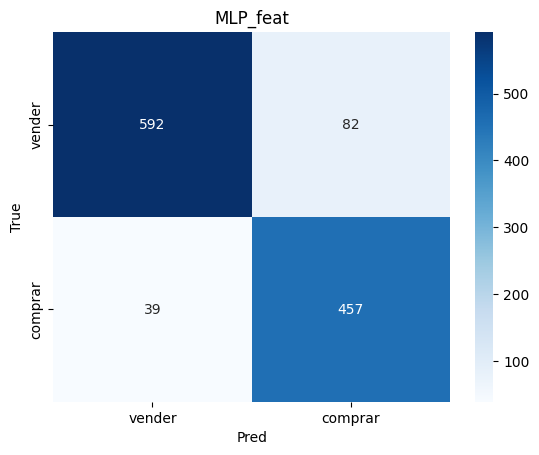

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

=== RNN_SEQ (Só sequência) ===
Accuracy: 0.888034188034188
              precision    recall  f1-score   support

      vender       0.92      0.88      0.90       674
     comprar       0.85      0.90      0.87       496

    accuracy                           0.89      1170
   macro avg       0.88      0.89      0.89      1170
weighted avg       0.89      0.89      0.89      1170

Tempo total: 53.08s


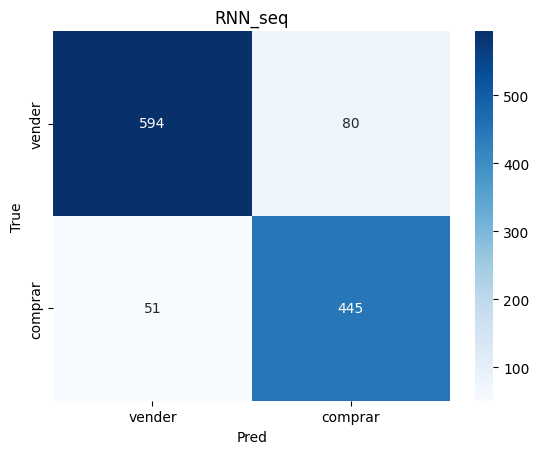

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== HYBRID_RNN_MLP (Híbrido) ===
Accuracy: 0.9102564102564102
              precision    recall  f1-score   support

      vender       0.93      0.91      0.92       674
     comprar       0.89      0.91      0.90       496

    accuracy                           0.91      1170
   macro avg       0.91      0.91      0.91      1170
weighted avg       0.91      0.91      0.91      1170

Tempo total: 46.87s


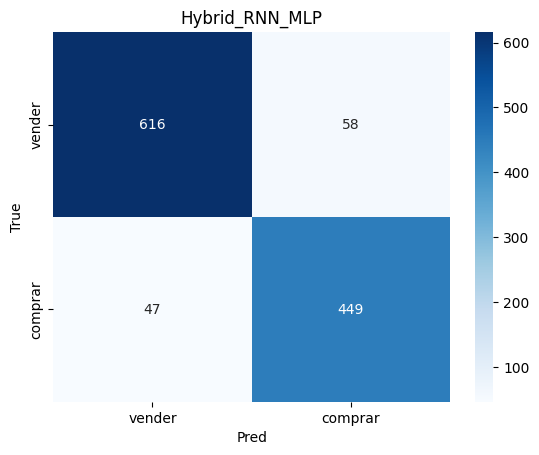


=== Comparativo de tempos (s) ===
MLP (features): 12.89
RNN (15d)    : 53.08
Híbrido      : 46.87


In [ ]:
# MLP
mlp_feat = build_mlp_feat(X_train_feat.shape[1])
mlp_feat, hist_mlp, y_prob_mlp, y_pred_mlp, t_mlp = train_eval_features(
    mlp_feat, X_train_feat, y_train, X_test_feat, y_test, name="MLP_feat"
)

# RNN
rnn_seq = build_rnn_seq(X_train_seq.shape[1:])
rnn_seq, hist_rnn, y_prob_rnn, y_pred_rnn, t_rnn = train_eval_sequence(
    rnn_seq, X_train_seq, y_train, X_test_seq, y_test, name="RNN_seq"
)

# Híbrido
hybrid_model = build_hybrid_rnn_mlp(X_train_seq.shape[1:], X_train_feat.shape[1])
hybrid_model, hist_hybrid, y_prob_hybrid, y_pred_hybrid, t_hyb = train_eval_hybrid(
    hybrid_model, X_train_seq, X_train_feat, y_train, X_test_seq, X_test_feat, y_test, name="Hybrid_RNN_MLP"
)


print("\n=== Comparativo de tempos (s) ===")
print(f"MLP (features): {t_mlp:.2f}")
print(f"RNN (15d)    : {t_rnn:.2f}")
print(f"Híbrido      : {t_hyb:.2f}")


Valor final MLP (features): R$ 17772.85
Valor final RNN (15d):      R$ 7307.46
Valor final Híbrido:        R$ 13954.32


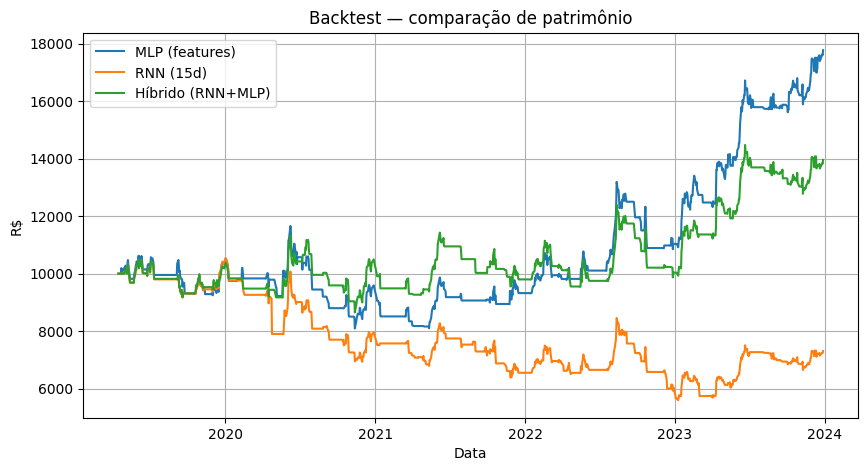

In [ ]:
def backtest_probs(probs, df, capital_inicial=10000, taxa=0.001):
    capital, pos = capital_inicial, 0.0
    patrimonio = []
    prices = df["Close"].values
    sig = (probs >= 0.5).astype(int)
    for i, s in enumerate(sig):
        p = prices[i]
        if s == 1 and capital > 0:        # compra
            q = (capital * (1 - taxa)) / p
            pos += q
            capital = 0
        elif s == 0 and pos > 0:          # vende
            capital += pos * p * (1 - taxa)
            pos = 0
        patrimonio.append(capital + pos * p)
    final = patrimonio[-1]
    return final, np.array(patrimonio)

# Roda o backtest para cada probabilidade
final_mlp, pat_mlp = backtest_probs(y_prob_mlp, df_test)
final_rnn, pat_rnn = backtest_probs(y_prob_rnn, df_test)
final_hyb, pat_hyb = backtest_probs(y_prob_hybrid, df_test)

print(f"Valor final MLP (features): R$ {final_mlp:.2f}")
print(f"Valor final RNN (15d):      R$ {final_rnn:.2f}")
print(f"Valor final Híbrido:        R$ {final_hyb:.2f}")

plt.figure(figsize=(10,5))
plt.plot(df_test["Date"], pat_mlp, label="MLP (features)")
plt.plot(df_test["Date"], pat_rnn, label="RNN (15d)")
plt.plot(df_test["Date"], pat_hyb, label="Híbrido (RNN+MLP)")
plt.title("Backtest — comparação de patrimônio")
plt.xlabel("Data"); plt.ylabel("R$"); plt.grid(True); plt.legend(); plt.show()


## Resultados

Por mais que a acurácia de todos os modelos tenha sido boa, sendo o modelo híbrido com o melhor resultado nesse parâmetro (~91%) e com precisão e recall equilibrados, chegamos em um retorno financeiro melhor quando utilizamos apenas o MPL com features.

O teste cumpriu o seu objetivo de analisar individualmente o impacto de adicionar um modelo para trabalhar apenas com as features. Melhorou a acurácia, mas não o desempenho financeiro, o que pode ter acontecido devido ao RNN ter dado prejuízo.

Alguns pontos podem explicar esse pior resultado, como:
- Aumento da complexidade pode fazer o modelo memorizar padrões de treino e não generalizar bem no teste;
- Ruído entre os modelos, já que as features são derivadas da sequência (também pode haver redundância);
- Resultado negativo do RNN puxou para baixo o positivo do MLP;
- Como a arquitetura é uma junção simples dos modelos, se uma das partes "domina", a outra pode atrapalhar na decisão;
- Por fim, o dataset da BBAS3 pode ter uma tendência mais forte ou ser mais sensível a padrões não temporais (o que beneficia ser apenas MLP).

Como futuros passos para enriquecer o projeto, vale uma investifação mais profunda, inclusive rodar o modelo híbrido com o outro dataset (BBAS3), mas por hora, seguimos para o próximo modelo.

Testamos o modelo com pior resultado financeiro nos testes anteriores para ver o impacto que utilizar um modelo híbrido traria, o que resultou em uma melhora, mas acabou sendo um resultado pior do que o MLP individual.
Futuros passos também incluem também analisar o uso de MLP + CNN 1D e MLP + LSTM, talvez com modelos que performaram melhor, podemos alcançar ainda melhores resultados.

# CSNA3 – Companhia Siderúrgica Nacional

Nesse ponto do projeto, temos que, para modelos focados em séries temporais, o uso de CNN 1D com a sequência de 15 dias mais as features, nos traz o melhor resultado (grande acurácia, precisão e recall, mas também bom resultado no backtest).


Agora, vamos criar um modelo com base nas imagens disponibilizadas, gráficos de barras dos últimos 15 dias de preço para cada dia de treino e teste.

# Importar dados

In [ ]:
import os, re, glob, time, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reprodutibilidade
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Caminhos (ajuste p/ seu Drive)
TRAIN_DIR = "/content/drive/MyDrive/FIAP_PI/CSNA3.SA/imagens/treino"
TEST_DIR  = "/content/drive/MyDrive/FIAP_PI/CSNA3.SA/imagens/teste"

# (Opcional p/ backtest) CSV de teste para pegar preços/data
CSV_TEST = "/content/drive/MyDrive/FIAP_PI/CSNA3.SA/teste.csv"

IMG_SIZE = (128, 128)      # padronização da entrada
BATCH    = 32
CLASS_NAMES = ['vender','comprar']  # 0, 1

# Preparar dados (Datasets treino e teste)

In [ ]:
# Data augmentation SUAVE (não altera ordem temporal)
data_augmentation = keras.Sequential([
    layers.RandomContrast(0.1),
    layers.RandomZoom(height_factor=0.05, width_factor=0.0),
])

def make_dataset(root_dir, shuffle):
    ds = tf.keras.utils.image_dataset_from_directory(
        root_dir,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,   # garante mapeamento 0=vender,1=comprar
        color_mode='grayscale',
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=shuffle,
        seed=SEED
    )
    # normalização [0,1]
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(TRAIN_DIR, shuffle=True)
test_ds  = make_dataset(TEST_DIR,  shuffle=False)


Found 4743 files belonging to 2 classes.
Found 1186 files belonging to 2 classes.


# Define o modelo

In [ ]:
def build_cnn2d(input_shape=(128,128,1)):
    inp = keras.Input(shape=input_shape, name="img")
    x = data_augmentation(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inp, out, name="CNN2D_CSNA3")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

cnn2d = build_cnn2d(IMG_SIZE + (1,))
cnn2d.summary()


Model: "CNN2D_CSNA3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,441 (396.25 KB)

 Non-trainable params: 448 (1.75 KB)

# Treino e avaliação

Epoch 1/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.8256 - loss: 0.4061 - val_accuracy: 0.4199 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 2/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8793 - loss: 0.2796 - val_accuracy: 0.4199 - val_loss: 3.1438 - learning_rate: 0.0010
Epoch 3/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8739 - loss: 0.2774 - val_accuracy: 0.8187 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 4/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8771 - loss: 0.2775 - val_accuracy: 0.7352 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 5/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8791 - loss: 0.2711 - val_accuracy: 0.8744 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 6/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8785 - loss: 0.2678 - val_accuracy: 0.8668 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 7/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8808 - loss: 

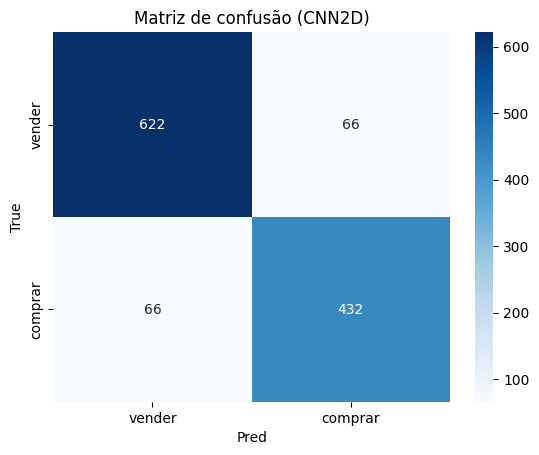

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
]

t0 = time.time()
hist = cnn2d.fit(train_ds, validation_data=test_ds, epochs=40, callbacks=callbacks, verbose=1)
treino_tempo = time.time() - t0
print(f"Tempo treino: {treino_tempo:.1f}s")

# Probabilidades e rótulos do teste
y_prob = cnn2d.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# y_true do test_ds
y_true = np.concatenate([y.numpy() for _, y in test_ds])

print("\n=== CNN2D_CSNA3 (imagens) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Matriz de confusão (CNN2D)"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()


# Backtest

Amostras carregadas p/ backtest: (1186, 128, 128, 1) 1186
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Linhas unidas (preço + sinal): (1186, 3)
Valor final (CNN2D): R$ 33087.92


/tmp/ipython-input-3140969069.py:47: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_test = pd.read_csv(CSV_TEST, parse_dates=['Date'], dayfirst=True)


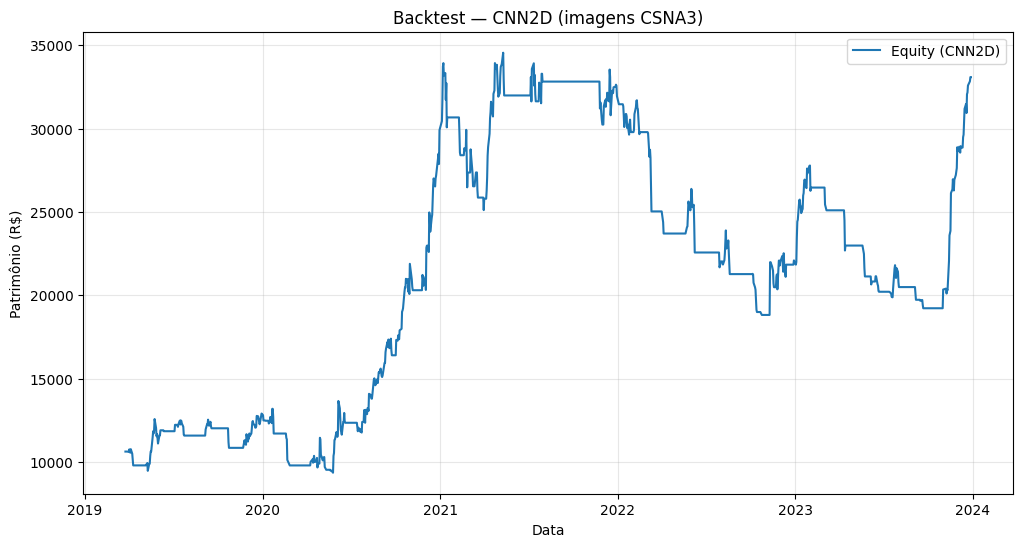

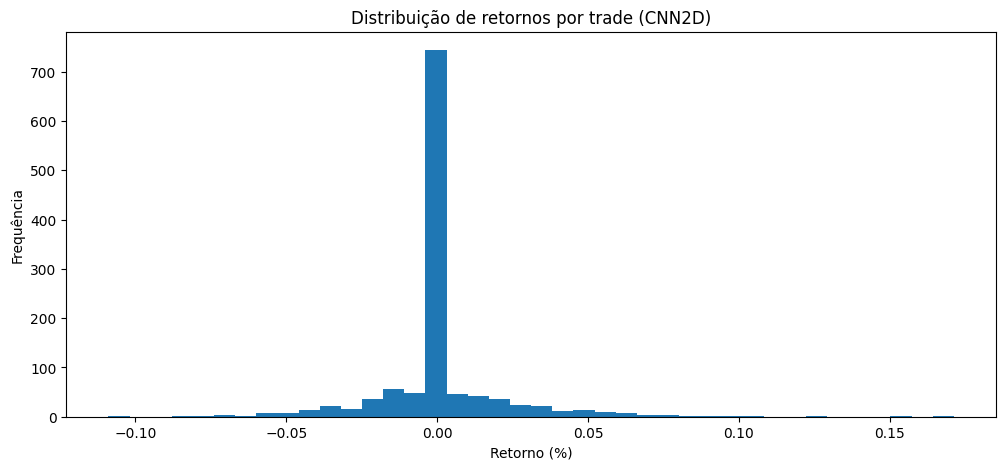

In [ ]:
# utilitários
def list_files_sorted_by_date(test_root):
    files = []
    for clase in CLASS_NAMES:  # vender/comprar
        pattern = os.path.join(test_root, clase, "*.png")
        for fp in glob.glob(pattern):
            fname = os.path.basename(fp)
            # extrai 'YYYY-MM-DD' antes do sublinhado
            m = re.match(r"(\d{4}-\d{2}-\d{2})_", fname)
            if not m:
                continue
            date = m.group(1)
            label = 1 if clase == "comprar" else 0
            files.append((fp, date, label))
    # ordena por data
    files.sort(key=lambda t: t[1])
    return files

def load_imgs(file_list, img_size):
    X = []
    dates = []
    labels = []
    for fp, dt, lab in file_list:
        img = tf.io.read_file(fp)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        X.append(img.numpy())
        dates.append(dt)
        labels.append(lab)
    X = np.stack(X, axis=0)
    y = np.array(labels, dtype=np.int32)
    return X, y, pd.to_datetime(dates)

# lista/ordena arquivos do teste e carrega
test_files = list_files_sorted_by_date(TEST_DIR)
X_test_img, y_test_img, dates_img = load_imgs(test_files, IMG_SIZE)

# garante que estamos comparando a mesma ordem
print("Amostras carregadas p/ backtest:", X_test_img.shape, len(dates_img))

# prevê diretamente no array (sem dataset)
y_prob_bt = cnn2d.predict(X_test_img, batch_size=64).ravel()
y_pred_bt = (y_prob_bt >= 0.5).astype(int)

# Carrega CSV de teste para pegar preços de fechamento nessa data
df_test = pd.read_csv(CSV_TEST, parse_dates=['Date'], dayfirst=True)
df_test = df_test[['Date','Close']].dropna().sort_values('Date').reset_index(drop=True)

# Une por data
df_pred = pd.DataFrame({"Date": dates_img, "pred": y_pred_bt})
df_merged = df_test.merge(df_pred, on='Date', how='inner').sort_values('Date').reset_index(drop=True)

print("Linhas unidas (preço + sinal):", df_merged.shape)

# Backtest simples (compra=1, vender=0; quando 0 ficamos fora)
def backtest(prices, preds, capital_inicial=10000.0):
    prices = prices.reset_index(drop=True)
    preds  = preds.astype(int)
    rets   = prices.pct_change().shift(-1).fillna(0.0)
    trades = preds * rets
    equity = (1 + trades).cumprod() * capital_inicial
    return equity, trades

equity, trades = backtest(df_merged['Close'], df_merged['pred'])
print(f"Valor final (CNN2D): R$ {equity.iloc[-1]:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df_merged['Date'], equity, label='Equity (CNN2D)')
plt.title("Backtest — CNN2D (imagens CSNA3)")
plt.xlabel("Data"); plt.ylabel("Patrimônio (R$)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
plt.hist(trades, bins=40)
plt.title("Distribuição de retornos por trade (CNN2D)")
plt.xlabel("Retorno (%)"); plt.ylabel("Frequência"); plt.show()
#testar log retorno das curvas

## Resultados

O modelo CNN 2D treinado com as imagens alcançou uma ótima acurácia (~88%) e relação de precisão x recall ótimo, sendo um modelo extremamente equilibrado.

O resultado financeiro foi o melhor de todos, tanto dos modelos para séries tempoarais (CNN 1D, RNN, LSTM) como com o modelo híbrido com MLP.

Esse resultado extremamente positivo financeiramente tem que ser levado com cautela, devido a alguns pontos importantes:
* Não sabemos as regras de suavização utilizadas nas imagens. O mesmo serve para os resultados com os CSVs, mas ter algo tão positivo nas imagens, pode gerar uma dúvida se a suavização feita não foi excessiva;
* A janela temporal que analisamos da CSNA3 pode também ter cooperado muito para o resultado positivo, visto o seu grande crescimento desde meados de 2020;
* Vale lembrar que modelos são avaliados financeiramente conforme a janela temporal utilizada. Se a janela fosse apenas ano de 2022, poderíamos ter dúvidas em relação a sua performance;
* Como estamos trabalhando e testando modelos com quatro empresas diferentes, um próximo passo muito importante para a Quantum Finance é testar as combinações utilizadas ao longo deste projeto em cada empresa individualmente. No caso, para VALE3, PTR4, BBAS3 e CSNA3, utilizar as combinações: (CNN1D, RNN, LSTM) sequência 15 dias, (CNN1D, RNN, LSTM) sequência 15 dias mais features, modelo híbrido com MLP, imagens com CNN 2D;
* Um modelo que não foi utilizado, mas também entra como próximos passos do projeto, é um modelo híbrido que trabalhe tanto com as imagens como com os CSVs;